In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# importing the 'Value' type
from utils import Value, MLP
from utils import PalindromeDataset, PalindromeDatasetFull

In [3]:
# Example computation
a = Value(1)
b = Value(2)
c = Value(3)
d = Value(4)

e = a*b + c*d
f = e/2.

# checking final values and initial grads (should be zero)
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

# backprop
f.backward()

# checking final grads
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

Value(data=14) Value(data=7.0) 0 0 0 0 0 0
Value(data=14) Value(data=7.0) 1.0 0.5 2.0 1.5 0.5 1


In [4]:
# showing the training of a simple NN, with some data
# input dim=3, output dim=1, atchitecture : NN with 4 layers : 3,4,4,1 neurons resp
from utils import MLP

# testing the MLP 
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1] # labels
losslog = []
a = MLP(3, [4,4,1])
for step in range(200) : # 200 epochs
    # forward pass
    ypred = [a(x)[0] for x in xs]
    loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

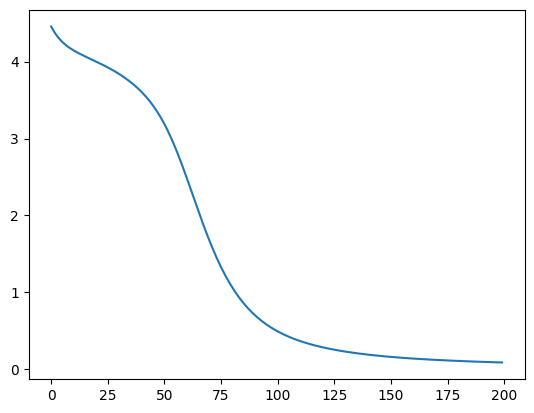

In [5]:
plt.plot(losslog)
plt.show()

In [6]:
# checking performance on the four data points
# should be close to ys=[1,-1,-1,1]
[a(x)[0] for x in xs]

[Value(data=0.8442281397216626),
 Value(data=-0.8781425781240726),
 Value(data=-0.8376995370875562),
 Value(data=0.8563240746183143)]

In [4]:
datasetMaker = PalindromeDataset(10)
dataset = datasetMaker.generate_dataset(512, 512)

In [5]:
len(dataset)

1024

In [6]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

In [7]:
# showing the training of a simple NN, with some data
# input dim=10, output dim=1, architecture : NN with 1 hidden layers : 4 with neurons
from utils import MLP
from tqdm.auto import tqdm

losslog = []
a = MLP(10, [4, 1])
weight = 1. # added weight to try and counter the class imbalance
nepochs = 751

xs, ys = convert_to_form(dataset)

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()

    if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

  0%|          | 0/751 [00:00<?, ?it/s]

epoch 0 loss 788.3568
epoch 50 loss 696.9919
epoch 100 loss 758.2818
epoch 150 loss 733.6958
epoch 200 loss 461.9446
epoch 250 loss 300.3326
epoch 300 loss 182.5484
epoch 350 loss 98.8221
epoch 400 loss 49.6473
epoch 450 loss 36.6525
epoch 500 loss 29.3177
epoch 550 loss 24.2300
epoch 600 loss 20.1680
epoch 650 loss 16.9218
epoch 700 loss 14.3778
epoch 750 loss 12.3834


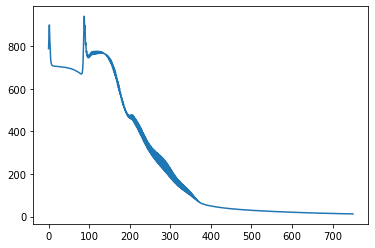

In [8]:
plt.plot(losslog)
plt.show()

In [9]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 0.9941 f1 0.9942
Threshold 0.2 accuracy 0.9971 f1 0.9971
Threshold 0.3 accuracy 0.9980 f1 0.9981
Threshold 0.4 accuracy 0.9990 f1 0.9990
Threshold 0.5 accuracy 1.0000 f1 1.0000
Threshold 0.6 accuracy 1.0000 f1 1.0000
Threshold 0.7 accuracy 1.0000 f1 1.0000
Threshold 0.8 accuracy 1.0000 f1 1.0000
Threshold 0.9 accuracy 1.0000 f1 1.0000


In [10]:
max(predictions), min(predictions)

(0.9955405997766498, 2.2640556458076842e-08)

In [11]:
from sklearn.metrics import confusion_matrix

# testing on full dataset
test_datasetMaker = PalindromeDatasetFull(10)
test_dataset = test_datasetMaker.generate_dataset()

xs, ys = convert_to_form(test_dataset)

predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    preds = 1*(predictions > i/10)

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)

    print(i/10, acc, f1)

confusion_matrix(ys, preds)

0.1 0.9501953125 0.5565217350170133
0.2 0.96484375 0.6399999955200001
0.3 0.9677734375 0.6597938098756511
0.4 0.9697265625 0.6736842059168976
0.5 0.97265625 0.6956521692249528
0.6 0.9755859375 0.7191011188284308
0.7 0.98046875 0.7619047570068028
0.8 0.9833984375 0.7901234518152721
0.9 0.986328125 0.8205128154635108


array([[978,  14],
       [  0,  32]], dtype=int64)

In [16]:
preds = 1*(predictions > 0.98)

true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

num_correct = true_neg + true_pos
prec = true_pos / (true_pos + false_pos + eps)
recall = true_pos / (true_pos + false_neg + eps)
f1 = 2*prec*recall / (prec + recall + eps)
acc = num_correct / len(ys)

print(i/10, acc, f1)

confusion_matrix(ys, preds)

0.9 0.98828125 0.8421052580609418


array([[980,  12],
       [  0,  32]], dtype=int64)